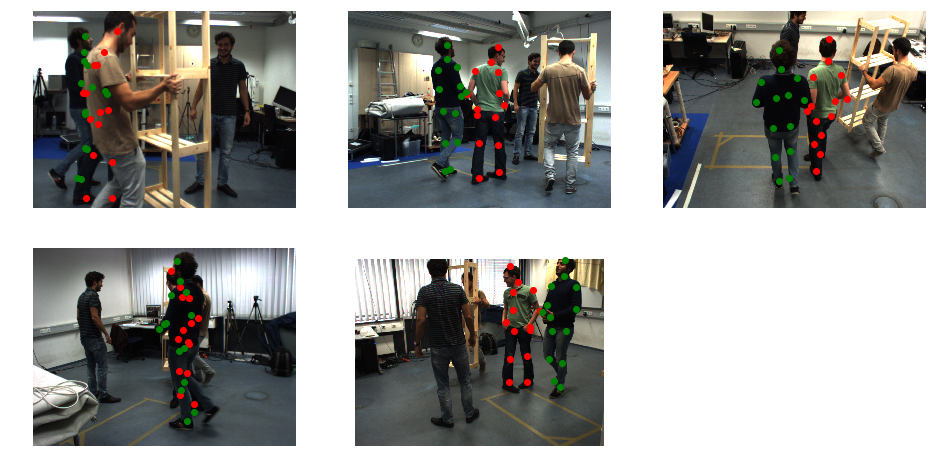

In [1]:
# Evaluation frames: [300 - 600].
# problematic frames: [539, 540]

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import shelf

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']


FRAME = 530

X, Y, Calib = shelf.get(root, FRAME)

fig = plt.figure(figsize=(16,8))

COLORS = ['red', 'green', 'blue', 'yellow']

for cid in [0, 1, 2, 3, 4]:
    ax = fig.add_subplot(2, 3, cid+1)
    cam = Calib[cid]
    im = X[cid]
    ax.imshow(im)
    ax.axis('off')
    
    for pid, person in enumerate(Y):
        pts3d = person
        if pts3d is None:
            continue
        
        pts2d = cam.projectPoints(pts3d)
        for u, v in pts2d:
            ax.scatter(u, v, color=COLORS[pid])

plt.show()

In [2]:
# ==================================
from mpl_toolkits.mplot3d import Axes3D
from mvpose import pose
from mvpose.settings import get_settings
import paf_loader
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human3d

Im, Y, Calib = shelf.get(root, FRAME)

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('shelf', 
                                                        Im, 
                                                        FRAME, 
                                                        dir=tmp)

#param = get_settings(scale_to_mm=1000)
# param = get_settings(
#     scale_to_mm=1000,
#     pp_conflict_overlap=0.8,
#     ms_radius=70,
#     ms_between_distance=70,
#     gp_max_radius=150
# )

param = get_settings(
    scale_to_mm=1000,
    ms_radius=400,
    ms_between_distance=100,
    gp_max_radius=130,
    pp_conflict_overlap=0.5
)


Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=param,
                                  debug=True)

print('\n# detections', len(detections))

Humans = detections

#fig = plt.figure(figsize=(16,12))

# colors = ['blue', 'red', 'yellow', 'cyan', 'green']

# for idx, cam in enumerate(Calib):
#     ax = fig.add_subplot(2, 3,1+idx)
#     ax.axis('off')
#     im = Im[idx]
#     h,w,_ = im.shape
#     ax.set_xlim([0, w])
#     ax.set_ylim([h, 0])
#     ax.imshow(im, alpha=1)
    
#     for pid, human in enumerate(Humans):
#         draw_mscoco_human(ax, human, cam, color=colors[pid])
        
# ax = fig.add_subplot(2, 3, 6, projection='3d')
# ax.set_xlim([-2, 2])
# ax.set_ylim([-2, 2])
# ax.set_zlim([0, 3])
# for pid, human in enumerate(Humans):
#     draw_mscoco_human3d(ax, human, color=colors[pid])
        
# plt.tight_layout()
# plt.show()

Using TensorFlow backend.


step 1: elapsed 1.248009204864502
step 2: elapsed 0.025120258331298828
step 3: elapsed 0.3230118751525879
step 4: elapsed 1.4505102634429932
-------------------------------------------
Handle transitivity:
	Intra:		 0
	Intra(choice):	 0
	Inter:		 0
	Inter(choice):	 27
-------------------------------------------
	Time =  27  ms
	result: 0

	Total cost: 77.78573956948733

# valid points:		 89
# invalid points:	 12
step 5: elapsed 0.030457258224487305
(smart candidate selection) [
	Time =  19  ms
	result: 0

	Total cost: 35.93023044240949
] (smart candidate selection)
step 6: elapsed 0.03657793998718262

# detections 4


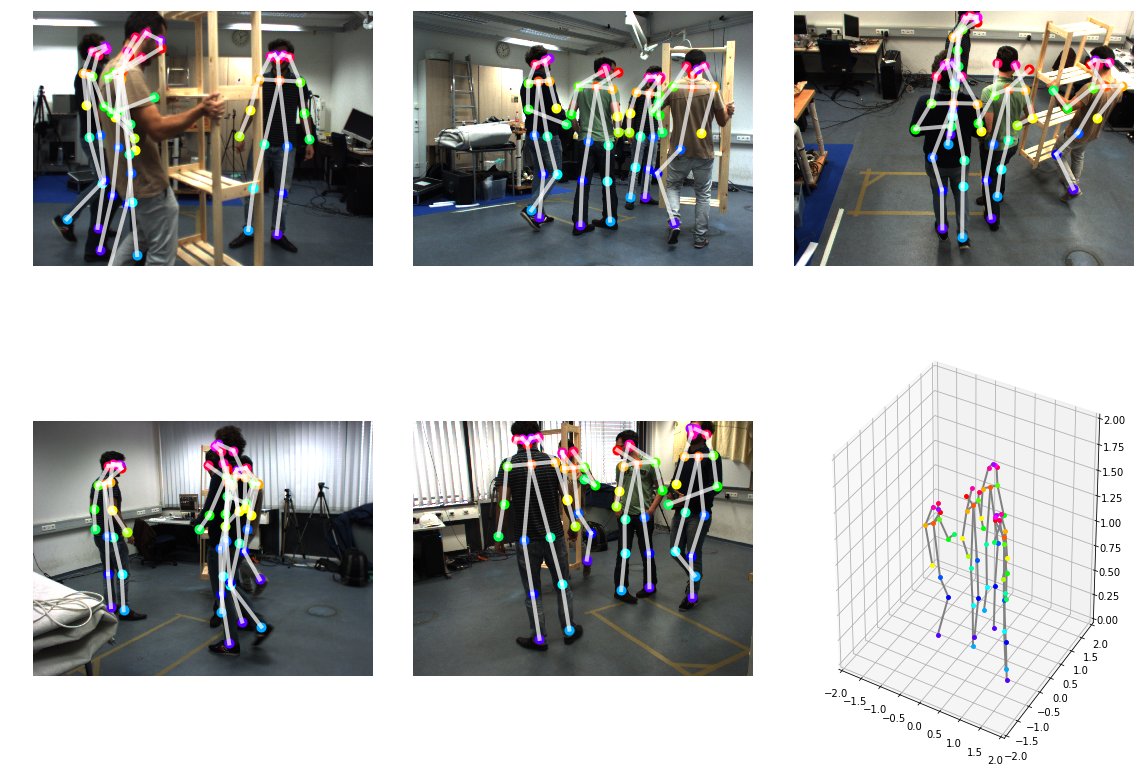

In [3]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

def draw_mscoco_human(ax, human, cam, alpha=1, linewidth=1):
    """
    :param ax
    :param human: [ (x,y), None, ... ]
    :param cam: {mvpose.geometry.camera}
    :param color
    :param alpha
    :param linewidth
    :return:
    """
    colors = cs.lincolor(19)/255
    color = 'white'
    
    for a, b in DEFAULT_LIMB_SEQ:
        ptA = human[a]
        ptB = human[b]
        if ptA is not None and ptB is not None:
            x_a, y_a = cam.projectPoints(np.array([ptA[0:3]]))[0]
            x_b, y_b = cam.projectPoints(np.array([ptB[0:3]]))[0]
            ax.plot([x_a, x_b], [y_a, y_b], color=color, 
                    alpha=0.7, linewidth=4)
    
    assert len(human) == 18
    for jid, pt3d in enumerate(human):
        if pt3d is None:
            continue
        pt = cam.projectPoints(np.array([pt3d[0:3]]))[0]
        ax.scatter(pt[0], pt[1], color=colors[jid], alpha=1,
                  linewidth=4)

def draw_mscoco_human3d(ax, human, alpha=1):
    """
    :param ax
    :param human: [ (x,y), None, ... ]
    :param cam: {mvpose.geometry.camera}
    :param color
    :param alpha
    :return:
    """
    colors = cs.lincolor(19)/255
    color = 'gray'
    assert len(human) == 18
    for jid, pt3d in enumerate(human):
        if pt3d is None:
            continue
        pt = pt3d[0:3]
        marker = '*'
        ax.scatter(pt[0], pt[1], pt[2], color=colors[jid], 
                   alpha=alpha, s=15)

    for a, b in DEFAULT_LIMB_SEQ:
        ptA = human[a]
        ptB = human[b]
        if ptA is not None and ptB is not None:
            x_a, y_a, z_a = ptA[0:3]
            x_b, y_b, z_b = ptB[0:3]
            ax.plot([x_a, x_b], [y_a, y_b], [z_a, z_b],
                    color=color, alpha=alpha, linewidth=2)



fig = plt.figure(figsize=(16,12))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=1)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam)
        
ax = fig.add_subplot(2, 3, 6, projection='3d')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([0, 2])
for pid, human in enumerate(Humans):
    draw_mscoco_human3d(ax, human)
        
plt.tight_layout()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

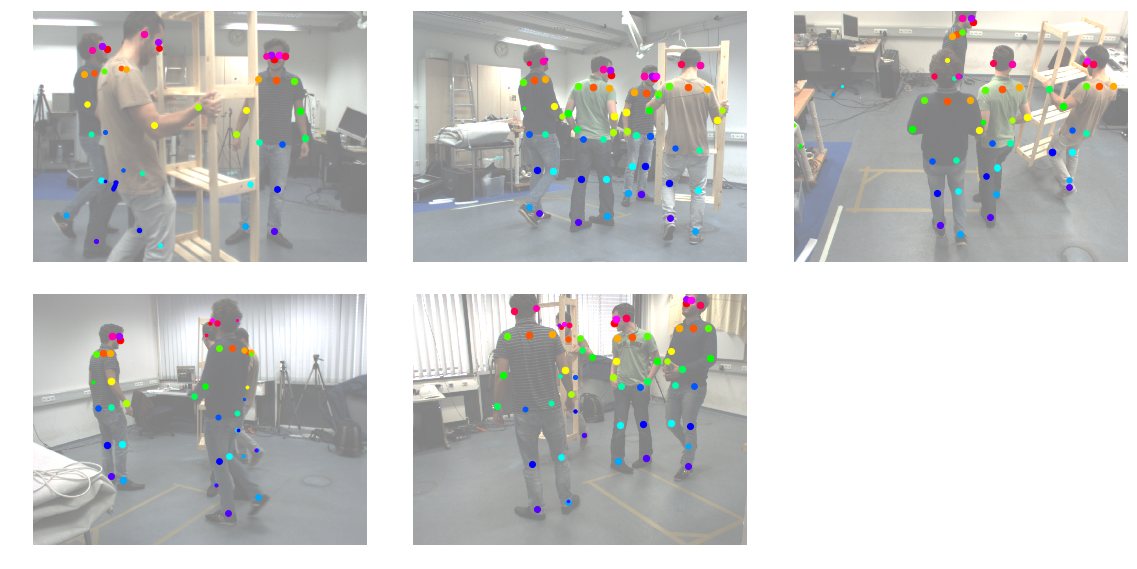

In [4]:
colors = cs.lincolor(19)/255
fig = plt.figure(figsize=(16,8))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(2, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    
    for jid in range(Debug.candidates2d.n_joints):
        for x,y,score in Debug.candidates2d.peaks2d_undistorted[cid][jid]:
            ax.scatter(x,y,s=score*50, c=colors[jid])
        
plt.tight_layout()
plt.show()

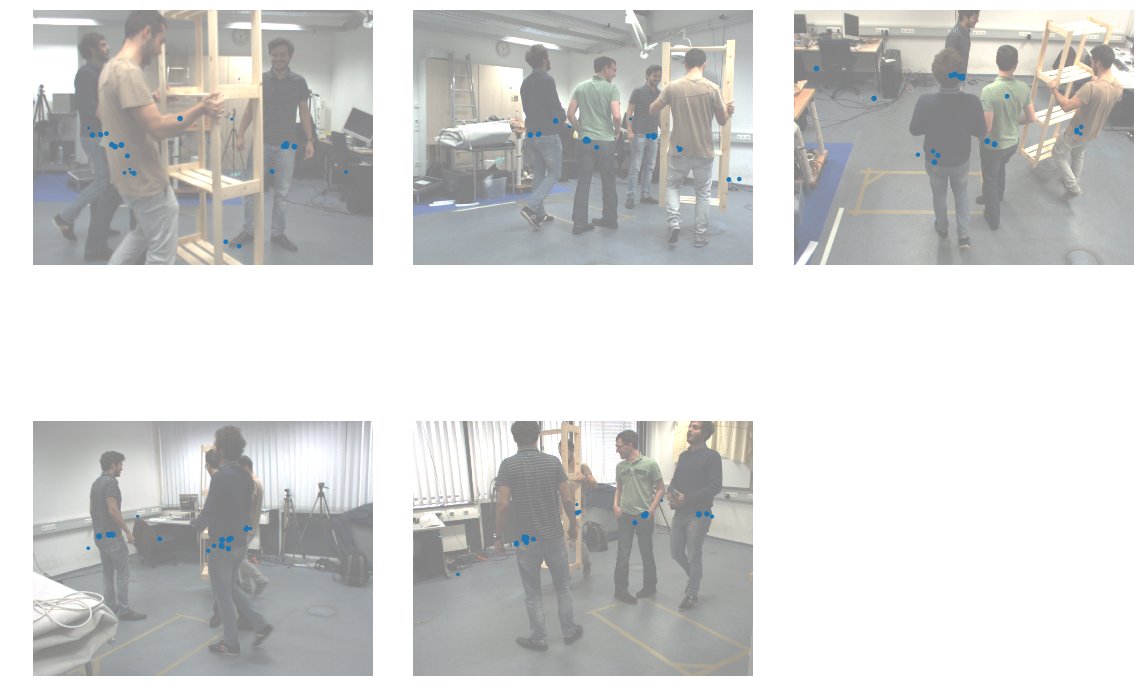

In [5]:
import mvpose.geometry as gm

JOINT = 11

pts3d_with_w = Debug.triangulation.peaks3d_weighted[JOINT]
pts3d = pts3d_with_w[:,0:3].astype('float32')


fig = plt.figure(figsize=(16,12))
for cid, (im, cam) in enumerate(zip(Im, Calib)):
    ax = fig.add_subplot(2, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    pts2d = cam.projectPoints_undist(pts3d)
    ax.scatter(pts2d[:,0], pts2d[:,1], 
               s=pts3d_with_w[:,3] * pts3d_with_w[:,4] * 50)
 
plt.tight_layout()
plt.show()

In [6]:
gc = Debug.graphcut
iota_sums = gc.iota_sums
lambda_sums = gc.lambda_sums

ALL = []

for lid, sums in enumerate(lambda_sums):
    if len(sums) == 0:
        continue
    ALL += sums
    

print('avg:', np.mean(ALL))
print('std:', np.std(ALL))
print('min:', np.min(ALL))
print('max:', np.max(ALL))

avg: 0.8673480476954666
std: 0.45685914322523663
min: -0.06741029691802616
max: 1.7881587335143283
